In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import hello_world, load_dataframes_fannie
hello_world()

Hello World!


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import environ
environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

In [3]:
fpath = "/data/stock_sentiment/AAII_Sentiment.json"
with open(fpath, 'r') as F:
    raw_sentiment = json.load(F)

In [4]:
print(len(raw_sentiment))

1


In [5]:
for key in raw_sentiment['dataset']:
    print(key)

id
dataset_code
database_code
name
description
refreshed_at
newest_available_date
oldest_available_date
column_names
frequency
type
premium
limit
transform
column_index
start_date
end_date
data
collapse
order
database_id


In [6]:
DATA = raw_sentiment['dataset']['data']
column_names = raw_sentiment['dataset']['column_names']

In [7]:
with open("sentiment_data.csv", 'w') as F:
    for line in DATA:
        F.write(",".join(f"{l}" for l in line)+"\n")

In [8]:
df = pd.read_csv(
    "sentiment_data.csv",
    header=None,
    names=column_names
)

In [9]:
df.head()

,Date,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
0,2019-11-07,0.403023,0.357683,0.239295,1.000001,0.31236625,0.163728,0.380795,0.481935,0.279655,3085.2,3023.19,3076.78
1,2019-10-31,0.339759,0.375904,0.284337,1.0,0.303394625,0.055422,0.380795,0.481935,0.279655,3050.1,2991.21,3046.77
2,2019-10-24,0.356021,0.361257,0.282723,1.000001,0.29672725,0.073298,0.380795,0.481935,0.279655,3014.57,2976.31,3004.52
3,2019-10-17,0.336182,0.353276,0.310541,0.999999,0.284888,0.025641,0.380795,0.481935,0.279655,3003.28,2907.41,2989.69
4,2019-10-10,0.203085,0.357326,0.439589,1.0,0.276159625,-0.236504,0.380795,0.481935,0.279655,2959.75,2855.94,2919.4


# Data Normalization and Column Creation



In [10]:
NaNones = df['Bullish 8-Week Mov Avg'] != "None"
df = df[NaNones]

In [11]:
for column in column_names:
    if column == "Date":
        continue
    df[column] = df[column].astype(np.float)
    
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=True)

In [12]:
idx = 0
key = 'S&P 500 Weekly High'
maxVal = df[key].max()
values = []
for row in df.iterrows():
    row = row[1]
    if idx == 0:
        prev = row[key]
        idx += 1
        values.append(0)
        continue
    val = (row[key] - prev)/prev
    # df.at[idx, "High_Change"] = (row[key] - prev)/prev
    # df.High_Change.iloc[idx] = val
    values.append(val)
    idx += 1
    prev = row[key]
    
print(np.max(values))
print(len(values))

0.11215208408304068
1670


In [13]:
df["High_Change"] = np.array(values)
df['High_Change']

1677    0.000000
1676    0.003416
1675   -0.005850
1674    0.021420
1673    0.000030
          ...   
4      -0.010954
3       0.014707
2       0.003759
1       0.011786
0       0.011508
Name: High_Change, Length: 1670, dtype: float64

In [14]:
df['High_Change'] = df["High_Change"] / np.max(np.abs(values))

In [15]:
df['High_Change']

1677    0.000000
1676    0.019143
1675   -0.032780
1674    0.120027
1673    0.000171
          ...   
4      -0.061380
3       0.082411
2       0.021065
1       0.066042
0       0.064483
Name: High_Change, Length: 1670, dtype: float64

Creating Data Objects
Running Plot Function


/home/capcolabs/Stevens/Machine-Learning-Algorithms/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


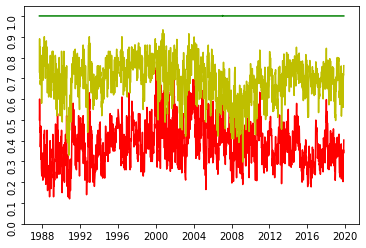

Done Running Plot Function


In [16]:
Bull = np.array(df['Bullish'].astype(np.float))
Neut = np.array(df['Neutral'].astype(np.float))
Bear = np.array(df['Bearish'].astype(np.float))
Time = df['Date']

print("Creating Data Objects")
X = Bull
Y = Neut + Bull
Z = Y + Bear

print("Running Plot Function")
plt.plot(Time, X, 'r')
plt.plot(Time, Y, 'y')
plt.plot(Time, Z, 'g')
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], rotation='vertical')
plt.show()
print("Done Running Plot Function")

# Create Training and Testing Data

In [17]:
idx = 0
seq_len = 45
X, y = [], []
for row in df.iterrows():
    row = row[1]
    if idx < seq_len:
        idx += 1
        continue
    data = df[
        ['Bullish', 'Neutral', 'Bearish', "High_Change"]
    ][idx-seq_len:idx-1]
    pred = row[['High_Change']
    ]
    X.append(np.array(data))
    y.append(np.array(pred))
    idx += 1
    
print(f"There are {len(X)} datapoints")
print(f'With {len(y)} labels')

There are 1625 datapoints
With 1625 labels


## Separate Train and Test

In [18]:
proportion = 0.8
number = int(proportion * len(X))

X_train, X_test = X[:number], X[number:]
y_train, y_test = y[:number], y[number:]

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)

y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
print(X_train.shape)
print(y_train.shape)

(1300, 44, 4)
(1300, 1)


In [19]:
import tensorflow as tf

In [20]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

SHUFFLE_BUFFER_SIZE = 256
BATCH_SIZE = 64

train_dataset = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset  = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

4
Epoch 1/5
21/21 - 5s - loss: 0.0929 - root_mean_squared_error: 0.1299 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/5
21/21 - 3s - loss: 0.0733 - root_mean_squared_error: 0.1072 - val_loss: 0.0409 - val_root_mean_squared_error: 0.0636
Epoch 3/5
21/21 - 4s - loss: 0.0727 - root_mean_squared_error: 0.1066 - val_loss: 0.0492 - val_root_mean_squared_error: 0.0640
Epoch 4/5
21/21 - 4s - loss: 0.0726 - root_mean_squared_error: 0.1064 - val_loss: 0.0435 - val_root_mean_squared_error: 0.0626
Epoch 5/5
21/21 - 4s - loss: 0.0720 - root_mean_squared_error: 0.1070 - val_loss: 0.0493 - val_root_mean_squared_error: 0.0629


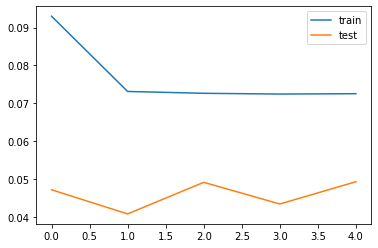

In [22]:
print(X_train.shape[2])
# design network
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.LSTM(
        512, 
        input_shape=(seq_len-1, X_train.shape[2]))
)

model.add(
    tf.keras.layers.Dense(1)
)
model.compile(
    loss='mae', 
    optimizer='adam',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError()
    ]
)
# fit network
history = model.fit(
    train_dataset, 
    epochs=5, 
    validation_data=test_dataset, 
    verbose=2)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(325, 1)
(325, 1)
0.0628724


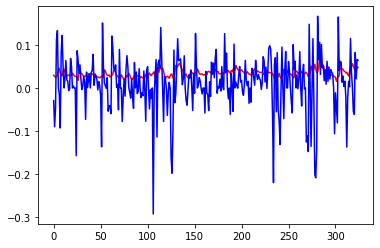

In [24]:

# make a prediction
yhat = model.predict(X_test)
print(yhat.shape)
print(y_test.shape)
ytest = y_test

Sep = np.square(yhat-ytest)
plt.plot(yhat*1.5, 'r')
plt.plot(ytest, 'b')

print(np.sqrt(np.mean(Sep)))

In [25]:
print(yhat.max())
print(yhat.min())

0.045277443
0.010211866
